In [152]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import cvxpy as cp
import pandas as pd
from networkx.algorithms.flow import edmonds_karp
import itertools

# Exercise 1

In [147]:
# Graph creation
G1 = nx.DiGraph()
G1.add_edges_from([
    ('o', 'a', {'capacity':3, 'key':'e1'}),
    ('o', 'b', {'capacity':3, 'key':'e3'}),
    ('a', 'b', {'capacity':1, 'key':'e6'}),
    ('b', 'c', {'capacity':3, 'key':'e4'}),
    ('a', 'd', {'capacity':3, 'key':'e2'}),
    ('c', 'd', {'capacity':2, 'key':'e5'})
])


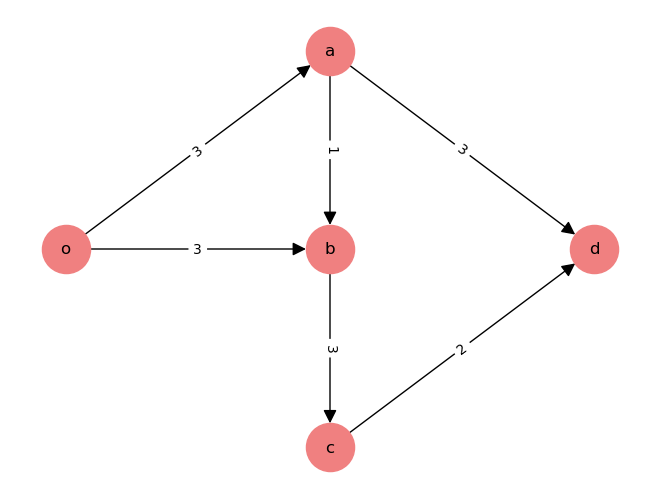

<Figure size 800x500 with 0 Axes>

In [148]:
pos = {'o': [0,1], 'a': [1,2], 'b': [1,1], 'c': [1,0], 'd': [2,1]}
nx.draw(G1, pos, with_labels=True, node_color='lightcoral', node_size=1200, arrows = True, arrowsize=20)

edge_labels = nx.get_edge_attributes(G1, 'capacity')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)
plt.figure(figsize=(8, 5))
plt.show()

#### (a) Compute the capacity of all the cuts and find the minimum capacity to be removed for no feasible flow from $o$ to $d$ to exist

In [149]:
#finding the minimum cut
nx.algorithms.flow.minimum_cut(G1,'o','d')

(5, ({'a', 'b', 'c', 'o'}, {'d'}))

In [150]:
#finding the maximum flow
nx.algorithms.flow.maximum_flow(G1,'o','d')

(5,
 {'o': {'a': 3, 'b': 2},
  'a': {'b': 0, 'd': 3},
  'b': {'c': 2},
  'c': {'d': 2},
  'd': {}})

#### (b) You are given $x > 0$ extra units of capacity $(x \in \Z)$. How should you distribute them in order to maximize the throughput that can be sent from $o$ to $d$?
Plot the maximum throughpu from $o$ to $d$ as a function of $x \geq 0$

#### (c) You are given the possibility of adding to the network a directed link e8 with capacity $c8 = 1$ and $x > 0$ extra units of capacity $(x \in \Z)$. Where should you add the link and how should you distribute the additional capacity in order to maximize the throughput that can be sent from $o$ to $d$?
Plot the maximum throughpu from $o$ to $d$ as a function of $x \geq 0$

# Exercise 2

In [74]:
# Graph creation
G2 = nx.Graph()

clique_nodes = [f"n{i}" for i in range(1, 6)]
for i in range(len(clique_nodes)):
    for j in range(i+1, len(clique_nodes)):
        G2.add_edge(clique_nodes[i], clique_nodes[j])

G2.add_edges_from([
    ("n7", "n8"),
    ("n8", "n9"),
    ("n6", "n15"),
    ("n6", "n1"), 
    ("n6", "n2"), 
    ("n6", "n3"),
    ("n6", "n4"), 
    ("n6", "n5"), 
    ("n6", "n7")
])

for i in range(10, 15):
    G2.add_edge("n9", f"n{i}")

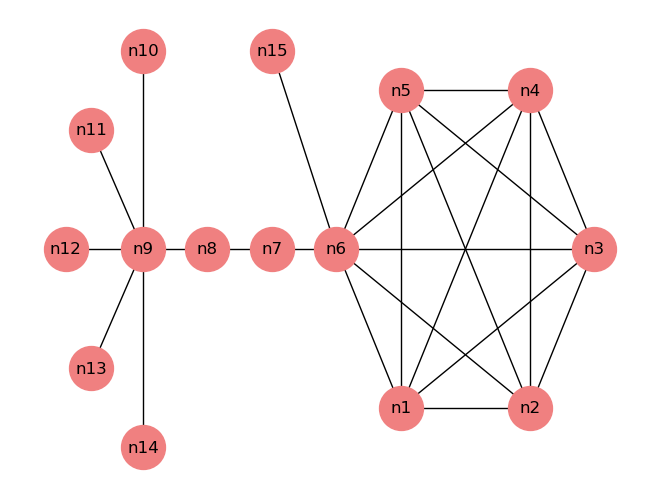

In [76]:
pos = {
    "n1": (2.0, -0.4),
    "n2": (3, -0.4),
    "n3": (3.5, 0.0),
    "n4": (3, 0.4),
    "n5": (2.0, 0.4),
    "n6": (1.5, 0.0),
    "n7": (1.0, 0.0),
    "n8": (0.5, 0.0),
    "n9": (0.0, 0.0),
    "n10": (0.0, 0.5),
    "n11": (-0.4, 0.3),
    "n12": (-0.6, 0.0),
    "n13": (-0.4, -0.3),
    "n14": (0.0, -0.5),
    "n15": (1.0, 0.5)
}

nx.draw(G2, pos, with_labels=True, node_color='lightcoral', node_size=1000)
plt.show()

#### (a) Compute the Katz centrality, with $\beta = 0.15$ and uniform intrinsic centrality $\mu$

In [78]:
# Compute matrices of the graph
W = nx.adjacency_matrix(G2)
W = W.toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

In [110]:
N = G2.number_of_nodes() 
beta = 0.15
mu = np.ones((N,1))/N

z_0 = np.ones((N,1))/N

# set a tolerance to assess convergence to the limit
tol = 1e-5

In [111]:
# initialize z
z_old = z_0

# Compute radius
eval, evec = np.linalg.eig(W)
eval = eval.real
radius = np.max(eval)


print("Radius of matrix W:"+str(radius))

while True:
    # define update rule of z
    z_new = W.T @ z_old * (1-beta)/radius + beta * mu
    if np.linalg.norm(z_new-z_old) < tol:
        break
    z_old=z_new

zk_distr = z_new

# normalize the centrality
zk_distr = zk_distr / sum(zk_distr)

zip_iterator = zip(G2.nodes(), zk_distr)
zb_dict = dict(zip_iterator)

print("Katz centrality:")
for key, value in zb_dict.items():
    print(f"{key}: {value}")

Radius of matrix W:5.071061467321913
Katz centrality:
n1: [0.11813757]
n2: [0.11813757]
n3: [0.11813757]
n4: [0.11813757]
n5: [0.11813757]
n7: [0.04424685]
n8: [0.03172152]
n9: [0.04281285]
n6: [0.13007854]
n15: [0.03892977]
n10: [0.02430452]
n11: [0.02430452]
n12: [0.02430452]
n13: [0.02430452]
n14: [0.02430452]


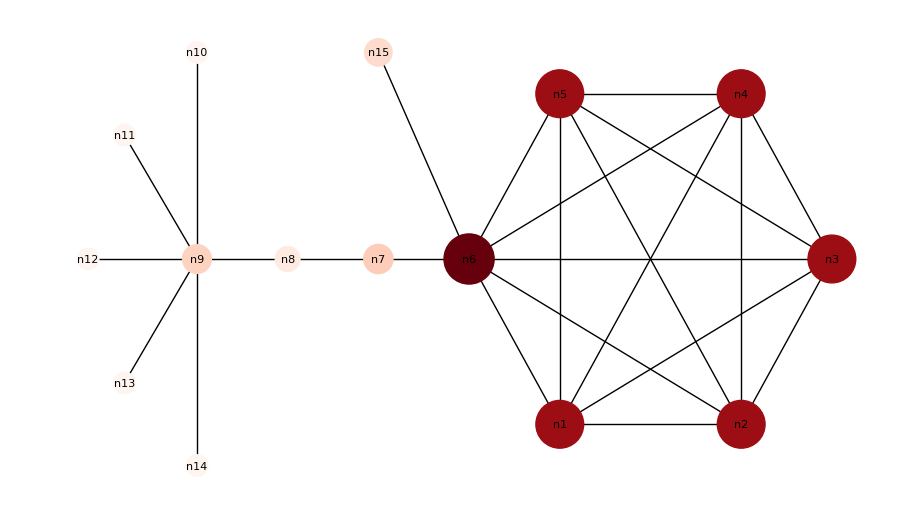

In [112]:
# visualization of Katz centrality
zk_reshape = zk_distr.reshape(N)
nodesize_k = zk_reshape * 10000

plt.figure(1, figsize=(9,5))
nx.draw(
    G2, pos,
    with_labels=True,
    nodelist=list(G2.nodes()),
    node_size=nodesize_k,
    node_color=zk_reshape,
    cmap=plt.cm.Reds,
    font_size=8
)
plt.show()

#### (b) Write a distributed algorithm for the computation of Page-rank centrality, with $\beta = 0.15$ and uniform intrinsic centrality $\mu$
$$
z = (\mathbf{I} - (1-\beta) P')^{-1} \beta \mu
$$

In [113]:
z_old = z_0

while True:
    # Update rule
    z_new = P.T @ z_old * (1-beta) + beta * mu
    # When |z^{k+1}-z^{k}|< tollerance stop iterating, we have already found an acceptable solution
    if np.linalg.norm(z_new-z_old) < tol:
        break
    z_old=z_new

zb_distr = z_new

# normalize the centrality
zb_distr = zb_distr / sum(zb_distr)


zip_iterator = zip(G2.nodes(), zb_distr)
zb_dict = dict(zip_iterator)

print("Bonachic centrality: ")
for key, value in zb_dict.items():
    print(f"{key}: {value}")

Bonachic centrality: 
n1: [0.07467977]
n2: [0.07467977]
n3: [0.07467977]
n4: [0.07467977]
n5: [0.07467977]
n7: [0.04861054]
n8: [0.05815016]
n9: [0.19404103]
n6: [0.11445073]
n15: [0.0238975]
n10: [0.03749024]
n11: [0.03749024]
n12: [0.03749024]
n13: [0.03749024]
n14: [0.03749024]


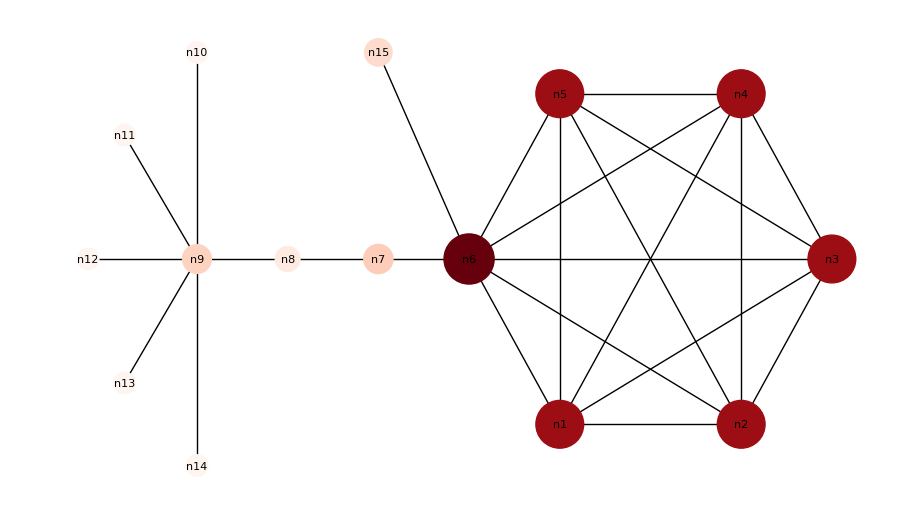

In [114]:
zb_reshape = zb_distr.reshape(N)
nodesize_b = zb_reshape * 10000

plt.figure(1, figsize=(9,5))
nx.draw(
    G2, pos,
    with_labels=True,
    nodelist=list(G2.nodes()),
    node_size=nodesize_k,
    node_color=zk_reshape,
    cmap=plt.cm.Reds,
    font_size=8
)
plt.show()

#### (c) Explain the results of points (a) and (b), focusing on the centralities of nodes $n6$ and $n9$


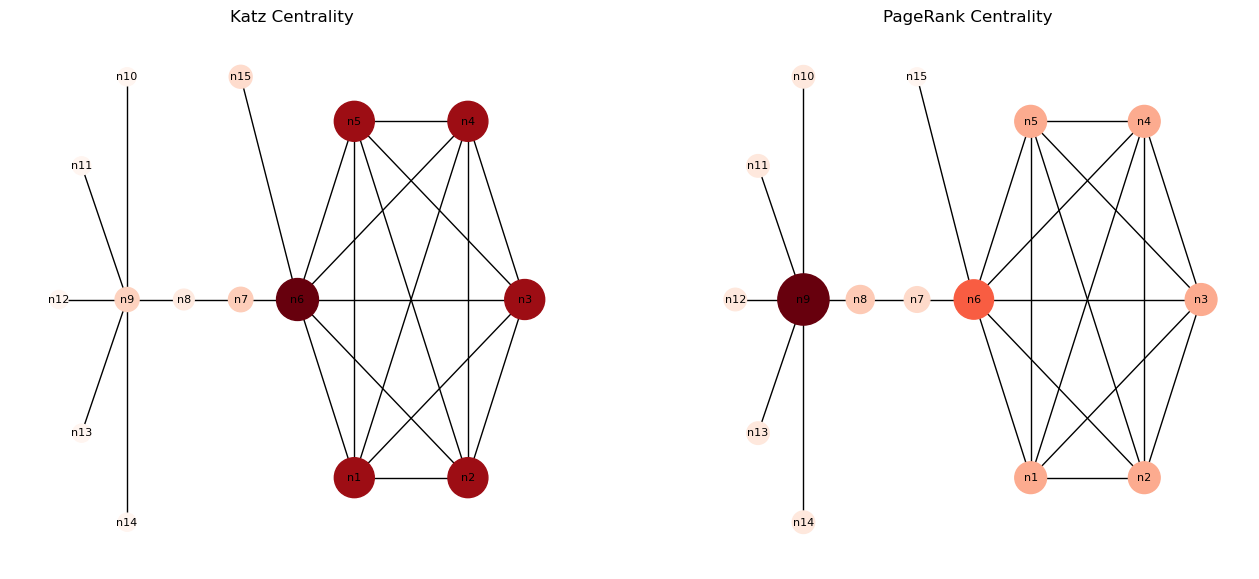

In [115]:
# reshape the centrality vectors and rescale for visualization
zk_reshape = zk_distr.reshape(N)
zb_reshape = zb_distr.reshape(N)
nodesize_k = zk_reshape * 7000
nodesize_b = zb_reshape * 7000



plt.figure(figsize=(16, 7))

# Katz centrality
plt.subplot(1, 2, 1)
nx.draw(
    G2, pos,
    with_labels=True,
    nodelist=list(G2.nodes()),
    node_size=nodesize_k,
    node_color=zk_reshape,
    cmap=plt.cm.Reds,
    font_size=8
)
plt.title("Katz Centrality", fontsize=12)

# PageRank centrality
plt.subplot(1, 2, 2)
nx.draw(
    G2, pos,
    with_labels=True,
    nodelist=list(G2.nodes()),
    node_size=nodesize_b,
    node_color=zb_reshape,
    cmap=plt.cm.Reds,
    font_size=8
)

plt.title("PageRank Centrality", fontsize=12)
plt.show()

#### (d) Compute the Page-Rank centrality with uniform intrinsic centrality $µ$ and for every$$\beta \in \{0,\frac{1}{4},\frac{2}{4},\frac{3}{4},1\} $$

In [116]:
def pagerank_iterative(P, beta, mu, tol=1e-5, max_iter=10000):
    if beta == 1.0:
        return mu.reshape(-1, 1)
    N = len(mu)
    z_old = np.ones((N, 1)) / N
    for _ in range(max_iter):
        z_new = (1 - beta) * (P.T @ z_old) + beta * mu.reshape(N, 1)
        if np.linalg.norm(z_new - z_old, ord=1) < tol:
            return z_new
        z_old = z_new
    return z_old

PageRank(n6) by β: {0.0: 0.14583351917185394, 0.25: 0.11060459536229676, 0.5: 0.10140405981519418, 0.75: 0.08750668778291992, 1.0: 0.06666666666666668}
PageRank(n9) by β: {0.0: 0.12499795017092834, 0.25: 0.19111449763773505, 0.5: 0.16669163847689578, 0.75: 0.12697705298002854, 1.0: 0.06666666666666668}
z[n6]-z[n9] by β: {0.0: 0.020835569000925605, 0.25: -0.08050990227543829, 0.5: -0.0652875786617016, 0.75: -0.039470365197108614, 1.0: 0.0}
Difference z[n6]-z[n9] is NOT monotone in β.


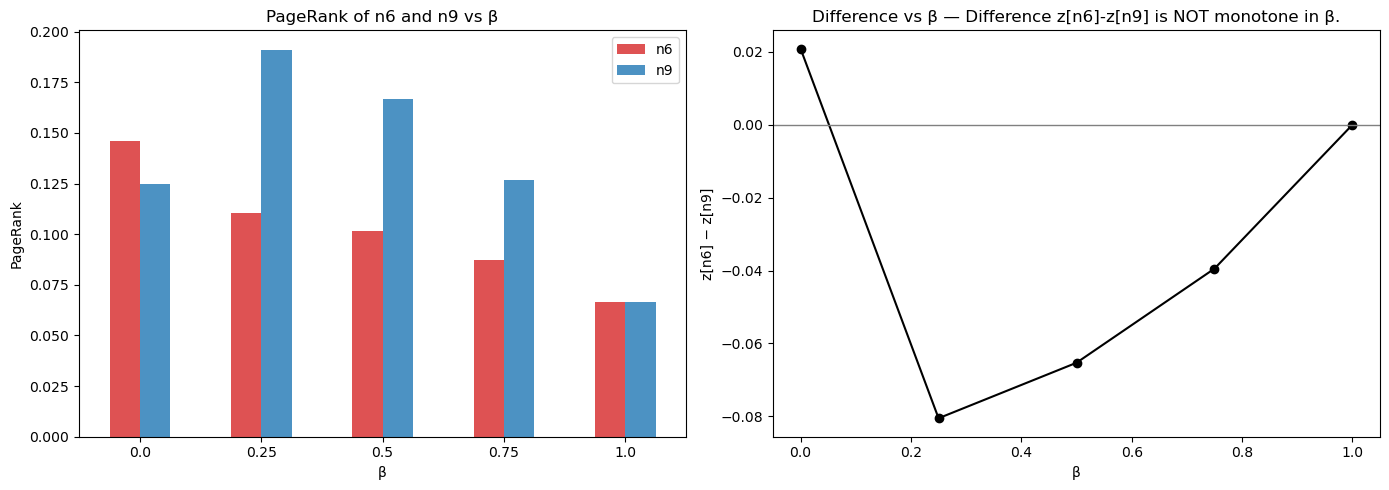

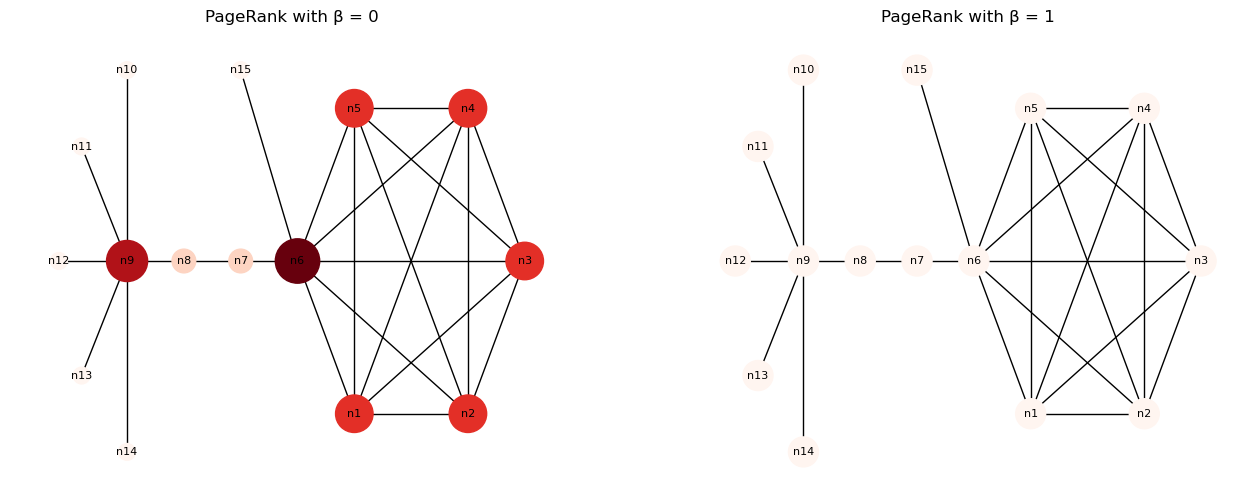

In [ ]:
P = W / degrees[:, None] # ???????????????

betas = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
N = G2.number_of_nodes()
mu = np.ones((N,)) / N


nodes = list(G2.nodes())
idx_n6 = nodes.index("n6")
idx_n9 = nodes.index("n9")
pr_results = {}
n6_vals, n9_vals, diff_vals = [], [], []

# compute PageRank for each β
for b in betas:
    z = pagerank_iterative(P, b, mu)
    z = (z / z.sum()).reshape(-1)
    pr_results[b] = z
    n6_vals.append(float(z[idx_n6]))
    n9_vals.append(float(z[idx_n9]))
    diff_vals.append(float(z[idx_n6] - z[idx_n9]))


# check whether the difference z[n6] - z[n9] is monotone in β
diff_vals = np.array(diff_vals)
eps = 1e-12
is_nondec = np.all(np.diff(diff_vals) >= -eps)
is_noninc = np.all(np.diff(diff_vals) <=  eps)
if is_nondec and not is_noninc:
    monotone_msg = "Difference z[n6]-z[n9] is non-decreasing in β."
elif is_noninc and not is_nondec:
    monotone_msg = "Difference z[n6]-z[n9] is non-decreasing in β."
    monotone_msg = "Difference z[n6]-z[n9] is non-increasing in β."
elif is_nondec and is_noninc:
    monotone_msg = "Difference z[n6]-z[n9] is constant in β."
else:
    monotone_msg = "Difference z[n6]-z[n9] is NOT monotone in β."

print("PageRank(n6) by β:", dict(zip(pd.Series(betas), n6_vals)))
print("PageRank(n9) by β:", dict(zip(pd.Series(betas), n9_vals)))
print("z[n6]-z[n9] by β:", dict(zip(pd.Series(betas), pd.Series(diff_vals))))
print(monotone_msg)

# plot 1
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# plot 1.1
centers = np.arange(len(betas))
group_width = 0.6
bar_width = 0.25
offset = bar_width / 2

x_n6 = centers - offset
x_n9 = centers + offset

ax[0].bar(x_n6, n6_vals, width=bar_width, label="n6", color="tab:red", alpha=0.8)
ax[0].bar(x_n9, n9_vals, width=bar_width, label="n9", color="tab:blue", alpha=0.8)

ax[0].set_xlabel("β")
ax[0].set_ylabel("PageRank")
ax[0].set_title("PageRank of n6 and n9 vs β")
ax[0].set_xticks(centers)
ax[0].set_xticklabels(betas)
ax[0].set_xlim(-0.5, len(betas) - 0.5)
ax[0].legend()


# plot 1.2
ax[1].plot(betas, diff_vals, marker="o", color="black")
ax[1].axhline(0.0, color="gray", linewidth=1)
ax[1].set_xlabel("β")
ax[1].set_ylabel("z[n6] − z[n9]")
ax[1].set_title(f"Difference vs β — {monotone_msg}")

plt.tight_layout()
plt.show()


# plot 2
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
nodesize_0 = 7000 * pr_results[0.0]
nx.draw(G2, pos, with_labels=True, nodelist=nodes, node_size=nodesize_0,
        node_color=pr_results[0.0], cmap=plt.cm.Reds, font_size=8)
plt.title("PageRank with β = 0")
plt.axis("off")

plt.subplot(1, 2, 2)
nodesize_1 = 7000 * pr_results[1.0]
nx.draw(G2, pos, with_labels=True, nodelist=nodes, node_size=nodesize_1,
        node_color=pr_results[1.0], cmap=plt.cm.Reds, font_size=8)
plt.title("PageRank with β = 1")
plt.axis("off")
plt.show()

# Exercise 3

In [154]:
try:
    f = sio.loadmat('flow.mat')["flow"].reshape(28,)
    C = sio.loadmat('capacities.mat')["capacities"].reshape(28,)
    B = sio.loadmat('traffic.mat')["traffic"]
    l = sio.loadmat('traveltime.mat')["traveltime"].reshape(28,)

except FileNotFoundError:
    print("Check that the .mat files are in the current directory")

In [155]:
#Graph costruction
G3 = nx.DiGraph()
num_nodes, num_edges = B.shape

#add nodes
G3.add_nodes_from(range(1, num_nodes + 1))

# add edges and capacities
for j in range(num_edges):
    src = np.where(B[:, j] == 1)[0][0] +1
    dst = np.where(B[:, j] == -1)[0][0] +1
    G3.add_edge(src, dst, capacity=int(C[j]), travel_time=l[j])

print(f"Graph construction completed:\n{G3.number_of_nodes()} nodes and {G3.number_of_edges()} edges")

Graph construction completed:
17 nodes and 28 edges


In [156]:
def check_non_negative_edges(G):
    for u, v, data in G.edges(data=True):
        if G[u][v]['travel_time'] < 0:
            return False
    return True

In [157]:
check_non_negative_edges(G3)

True

#### Draw the graph

In [158]:
pos = {
    1: (0, 7.5),
    2: (3.5, 7.5),
    3: (6, 7.5),
    4: (8.5, 7.5),
    5: (13, 7.5),
    6: (1.5, 5.5),
    7: (3.5, 5.5),
    8: (6, 5.5),
    9: (8.5, 5.5),
    10: (3.5, 3.5),
    11: (6, 3.5),
    12: (8.5, 3.5),
    13: (11, 3.5),
    14: (13, 3.5),
    15: (6, 1.5),
    16: (8.5, 1.5),
    17: (12.5, 1.5)
}

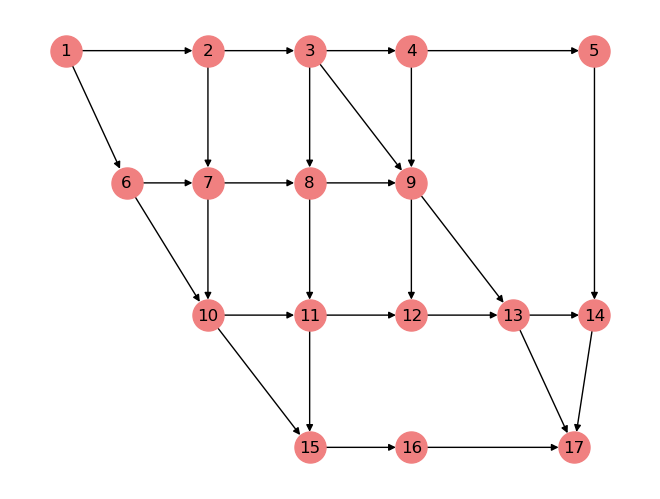

In [159]:
nx.draw(G3, pos, with_labels=True, node_color='lightcoral', node_size=500)
plt.show()

#### (a) Find the shortest path between node $1$ and $17$

In [160]:
# with NetworkX function (Djikstra)

sp = nx.shortest_path(G3, source=1, target=17, weight='travel_time')

# formatting the output path
elements = [str(x) for x in sp]
path = " -> ".join(elements)
print(path)

total_travel_time = sum(G3[sp[i]][sp[i+1]]['travel_time'] for i in range(len(sp)-1))
print("Total travel time along the shortest path:", total_travel_time)

1 -> 2 -> 3 -> 9 -> 13 -> 17
Total travel time along the shortest path: 0.559833


In [ ]:
# ===============================================================
# (1) is_internal_reachable_set()
# ---------------------------------------------------------------
# Goal:
#   Check whether a subset of nodes U is internally reachable from the source node s.
#
# Logic:
#   1. U must contain the source node s.
#   2. Starting from s, perform a DFS (or BFS) restricted to nodes in U.
#   3. If all nodes in U are reachable from s within U, then U is "internally closed"
#      and therefore valid.
#   4. Otherwise, if any node in U cannot be reached using only nodes of U, 
#      it means an intermediate node is missing → U is invalid.
# ===============================================================
def is_internal_reachable_set(G: nx.DiGraph, U: set, s) -> bool:
    """Return True if every node in U is reachable from s using only nodes inside U."""
    if s not in U:
        return False
    seen = {s}
    stack = [s]
    while stack:
        u = stack.pop()
        for v in G.successors(u):
            if v in U and v not in seen:
                seen.add(v)
                stack.append(v)
    return seen == U  # All nodes in U are reachable from s within U


# ===============================================================
# (2) cut_capacity_and_edges()
# ---------------------------------------------------------------
# Goal:
#   Compute the total capacity of a given cut (U, V\U) and the list of edges that cross it.
#
# Logic:
#   1. Identify the complement T = V \ U.
#   2. For every node u in U, check each outgoing edge (u, v).
#   3. If v ∈ T (the other side of the cut), that edge contributes to the cut capacity.
#   4. Sum all such edge capacities and store the list of cut edges.
# ===============================================================
def cut_capacity_and_edges(G: nx.DiGraph, U: set, cap: str = 'capacity'):
    """Return the total capacity and edge list for the cut (U, V\\U)."""
    T = set(G.nodes()) - U
    cap_sum = 0
    cut_edges = []
    for u in U:
        for v in G.successors(u):
            if v in T:
                w = G[u][v].get(cap, 0)
                cap_sum += w
                cut_edges.append((u, v))
    return cap_sum, tuple(cut_edges)


# ===============================================================
# (3) enumerate_valid_cuts()
# ---------------------------------------------------------------
# Goal:
#   Enumerate all possible subsets U ⊆ V such that:
#     - s ∈ U, t ∉ U  (source is inside, sink is outside)
#     - U is internally reachable from s (no missing intermediate nodes)
#
# Logic:
#   1. List all nodes except s and t (they are fixed).
#   2. Generate all possible combinations of these nodes (power set).
#   3. For each combination:
#        a. Add s to form U.
#        b. Skip if t ∈ U.
#        c. Check internal reachability: if False → skip.
#        d. If valid, compute capacity and edge list.
#   4. Return all valid cuts with their attributes.
#
# Complexity:
#   Exponential in number of nodes (2^(n-2)), but fine for small graphs.
# ===============================================================
def enumerate_valid_cuts(G: nx.DiGraph, s, t, cap: str = 'capacity'):
    """
    Generate all node subsets U that represent valid s–t cuts.
    A cut is valid if:
        (1) s ∈ U
        (2) t ∉ U
        (3) every node in U is reachable from s using only nodes in U
    """
    nodes = list(G.nodes())
    nodes.remove(s)
    if t in nodes:
        nodes.remove(t)

    valid_cuts = []
    # Generate all combinations of remaining nodes
    for r in range(len(nodes) + 1):
        for subset in itertools.combinations(nodes, r):
            U = set(subset) | {s}
            if t in U:
                continue
            # Condition check: internal reachability closure
            if not is_internal_reachable_set(G, U, s):
                continue  # Skip illegal combinations (missing intermediates)
            cap_sum, edges = cut_capacity_and_edges(G, U, cap=cap)
            valid_cuts.append({'U': U, 'cap': cap_sum, 'edges': edges})
    return valid_cuts


s, t = 'o', 'd'
cuts = enumerate_valid_cuts(G3, s, t, cap='capacity')
cuts.sort(key=lambda c: (c['cap'], sorted(c['U'])))

print("Number of valid cuts:", len(cuts))
print("First 5 valid cuts (sorted by capacity):")
for c in cuts[:5]:
    print(f"  cap={c['cap']}, U={sorted(c['U'])}, edges={c['edges']}")

if cuts:
    print("Minimum cut capacity (from valid combinations):", cuts[0]['cap'])

#### (b) Find the maximum flow between node $1$ and $17$


In [ ]:
mf = nx.flow.maximum_flow(G3, 1, 17, capacity='capacity', flow_func=edmonds_karp)
print("Maximum flow value from node 1 to node 17:", mf[0])

Maximum flow value from node 1 to node 17: 22448


#### (c) Given the flow vector in flow.mat, compute the vector $v$ satisfying $Bf = ν$

In [30]:
nu = B @ f
print("Vector ν satisfying Bf = ν:", nu)

Vector ν satisfying Bf = ν: [ 16806   8570  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


In [31]:
# check
nu.sum() == 0

np.True_

#### (d) Find the social optimum $f^∗$ with respect to the delays on the different links $τ_e(f_e)$. For this, minimize the cost function $$\sum_{e \in \mathcal E}f_e \tau_e (f(e)) = \sum_{e \in \mathcal E} \frac {f_e l_e}{1 - f_e / c_e} = \sum_{e \in \mathcal E}(\frac {l_ec_e}{1-f_e/c_e}-l_ec_e)$$ subject to the flow constraints


In [ ]:
def compute_total_delay(f, func='regular'):
    if func == 'regular':
        return np.sum(l * C / (1 - f / C) - l * C)
    elif func == 'new':
        return np.sum(l * C / (1 - f / C) - l * C + f * C)

In [130]:
n_edges = B.shape[1]
nu_source = nu[0]
nu_sink = -nu_source
nu = np.zeros(B.shape[0])
nu[0] = nu_source
nu[-1] = nu_sink

In [131]:
# construct the problem
f_opt = cp.Variable(n_edges)

# numerator
num = l * C

# denomiator
den = 1 - cp.multiply(f_opt, cp.inv_pos(C))
inv_den  = cp.inv_pos(den)
term1 = cp.multiply(num, inv_den)
cost = term1 - num

objective = cp.Minimize(cp.sum(cost))
constraints = [B @ f_opt == nu, f_opt >=0, f_opt <= C]
prob = cp.Problem(objective, constraints)

# solve the problem
total_delay = prob.solve() #which solver?
flow_opt = f_opt.value
print("Optimal flow values on edges:", flow_opt)

Optimal flow values on edges: [6.56934343e+03 5.81000870e+03 3.04697202e+03 3.04697044e+03
 1.02366566e+04 4.66633524e+03 3.06121109e+03 2.59598535e+03
 3.10455509e+03 7.59334729e+02 5.72744560e-03 2.76303096e+03
 1.57821332e-03 3.04697044e+03 5.57032133e+03 2.89383855e+03
 5.04094165e+03 2.36445888e+03 4.65231471e+02 2.25446280e+03
 3.35906803e+03 5.61353083e+03 2.37198823e+03 1.99673781e-03
 6.34609768e+03 5.41895867e+03 5.04094365e+03 5.04094365e+03]


In [132]:
print("Total delay with optimal flow:", total_delay)

Total delay with optimal flow: 26142.669749995475


#### (e) Find the Wardrop equilibrium $f^{(0)}$. For this, use the cost function $$\psi_e(f_e) = \sum_{e \in \mathcal E} \int_{0}^{f_e} \tau_e(s)ds = -\sum_{e \in \mathcal E} l_ec_e \text{ln}(1 - \frac {f_e}{c_e})$$

In [133]:
# construct the problem
f_w = cp.Variable(n_edges)

objective_w = cp.sum(cp.multiply(-l * C, cp.log(1 - cp.multiply(f_w, cp.inv_pos(C)))))
constraints_w = [B @ f_w == nu, f_w >=0, f_w <= C]
prob_w = cp.Problem(cp.Minimize(objective_w), constraints_w)

# solve the problem
f_w_opt = prob_w.solve()
flow_war = f_w.value
print("Wardrop equilibrium:", flow_war)

Wardrop equilibrium: [6.55752880e+03 6.30856524e+03 2.20068400e+03 2.20068399e+03
 1.02484712e+04 4.70668091e+03 2.86004234e+03 2.23275882e+03
 3.35000775e+03 2.48963554e+02 1.16567931e+01 4.09622445e+03
 1.02921940e-05 2.20068399e+03 5.54179029e+03 2.34330113e+03
 5.29409128e+03 2.09560213e+03 6.38940315e+02 2.97897553e+03
 2.98224143e+03 5.96121696e+03 2.52233127e+03 1.59560460e-05
 6.78889343e+03 4.72301527e+03 5.29409130e+03 5.29409130e+03]


In [134]:
total_delay_we = compute_total_delay(flow_war)
print("Total delay at Wardrop equilibrium:", total_delay_we)

Total delay at Wardrop equilibrium: 26495.316091667042


In [145]:
price_of_anarchy = total_delay_we / total_delay
print("Price of Anarchy: price_of_anarchy")

Price of Anarchy: price_of_anarchy


#### (f) Introduce tolls $\omega_e = (f_e^*)\tau_e'(f_e^*)$ and compute the new Wardrop equilibrium $f^{(ω)}$

In [ ]:
# construct the problem
f_toll = cp.Variable(n_edges)

# tolls
omega = cp.multiply(f_opt.value, cp.multiply(l, cp.inv_pos(cp.multiply(C, cp.power(1 - f_opt.value / C, 2)))))
log_term_omega = cp.log(1 - f_toll / C)

objective_toll = cp.sum(cp.multiply(-l *C, log_term_omega))
constraints_toll = [B @ f_toll == nu, f_toll >=0, f_toll <= C]
prob_toll = cp.Problem(cp.Minimize(objective_toll + omega.T @ f_toll), constraints_toll)

# solve the problem
res_toll = prob_toll.solve()
flow_toll = f_toll.value
print("Wardrop equilibrium with tolls:", flow_toll)

Wardrop equilibrium with tolls: [6.56814657e+03 5.80983600e+03 3.04693783e+03 3.04693779e+03
 1.02378534e+04 4.66755786e+03 3.06128318e+03 2.59610108e+03
 3.10454807e+03 7.58310577e+02 1.10409759e-04 2.76289806e+03
 4.03744492e-05 3.04693779e+03 5.57029554e+03 2.89393227e+03
 5.04094853e+03 2.36458526e+03 4.65182217e+02 2.25445110e+03
 3.35911443e+03 5.61356553e+03 2.37199826e+03 5.95258138e-05
 6.34611534e+03 5.41893605e+03 5.04094859e+03 5.04094859e+03]


In [137]:
total_delay_tolls = compute_total_delay(flow_toll)
print("Total delay with tolls at optimal flow:", total_delay_tolls)

Total delay with tolls at optimal flow: 26142.67138356156


In [138]:
price_of_anarchy = total_delay_tolls / total_delay
print("Price of Anarchy: ", price_of_anarchy)

Price of Anarchy:  1.0000000624865824


#### (g) Let the cost for the system be the total additional travel time compared to the total travel time in free flow, given by $$\psi_e(f_e) = f_e(\tau_e(f_e)-l_e)$$ subject to the flow constraints

In [139]:
def compute_total_delay_at_comp(f):
    return np.sum(((l * C) / (1 - f / C) - (l * C)) - (f * l)
)

##### - Compute the system optimum $f^∗$

In [140]:
f_comp = cp.Variable(n_edges)

obj_comp = cp.Minimize(
    cp.sum(cp.multiply(cp.multiply(l, C), cp.inv_pos(1 - cp.multiply(f_comp, cp.inv_pos(C)))) - cp.multiply(l, C) - cp.multiply(f_comp, l)) 
)

const_comp = [B @ f_comp == nu, f_comp >=0, f_comp <= C]
prob_comp = cp.Problem(obj_comp, const_comp)

# solve the problem
cost_comp = prob_comp.solve()
flow_comp = f_comp.value
print("Compared additional vs free travel optimal flow:", flow_comp)
print("Optimal cost:", cost_comp)

Compared additional vs free travel optimal flow: [6.58451091e+03 5.57770824e+03 3.36756475e+03 3.36755932e+03
 1.02214891e+04 4.66944310e+03 3.15651862e+03 2.71195152e+03
 2.98789183e+03 1.00680267e+03 3.72678946e-03 2.21013977e+03
 5.42668359e-03 3.36755932e+03 5.55204599e+03 3.08485436e+03
 4.98691878e+03 2.51972715e+03 4.44570825e+02 1.93420488e+03
 3.52942308e+03 5.46362796e+03 2.20221142e+03 2.10795648e-03
 6.24930837e+03 5.56977074e+03 4.98692089e+03 4.98692089e+03]
Optimal cost: 15350.354156595688


In [141]:
social_cost_at_comp = compute_total_delay_at_comp(flow_comp)

social_cost_at_comp_war = compute_total_delay_at_comp(f_w.value)
print("Social Optimum Cost (min total delay): ", cost_comp)
print("Cost as Wardrop equilibrium over new social cost: ", social_cost_at_comp_war)

Social Optimum Cost (min total delay):  15350.354156595688
Cost as Wardrop equilibrium over new social cost:  15982.18015052396


In [ ]:
price_of_anarchy = social_cost_at_comp_war / social_cost_at_comp
print(f"Price of Anarchy: {price_of_anarchy}")

Price of Anarchy: 1.0411603528806397


##### - Compute the new Wardrop equilibrium with the constructed tolls $f^{(w^*)}$ to verify the result

In [142]:
# construct the problem
f_comp_toll = cp.Variable(n_edges)

# tolls
omega_comp = flow_comp * (l / (C * (1 - flow_comp/C)**2)) - l

obj_comp_toll = cp.Minimize(
    cp.sum(-1 * cp.multiply(cp.multiply(l, C), cp.log(1 - cp.multiply(f_comp_toll, cp.inv_pos(C)))) + cp.multiply(f_comp_toll, omega_comp))
)

const_comp_toll = [B @ f_comp_toll == nu, f_comp_toll >=0, f_comp_toll <= C]
prob_comp_toll = cp.Problem(obj_comp_toll, const_comp_toll)

# solve the problem
cost_comp_toll = prob_comp_toll.solve()
flow_comp_toll = f_comp_toll.value
print("Compared additional vs free travel optimal flow:", flow_comp_toll)
print("Optimal cost:", cost_comp_toll)

Compared additional vs free travel optimal flow: [6.58402067e+03 5.57848628e+03 3.36715451e+03 3.36715433e+03
 1.02219793e+04 4.66966518e+03 3.15618464e+03 2.71143895e+03
 2.98814597e+03 1.00553439e+03 1.26825292e-04 2.21133164e+03
 1.76910929e-04 3.36715433e+03 5.55231413e+03 3.08448187e+03
 4.98684720e+03 2.51901493e+03 4.44745826e+02 1.93462479e+03
 3.52922761e+03 5.46385240e+03 2.20261272e+03 8.34855998e-05
 6.24938565e+03 5.56976706e+03 4.98684728e+03 4.98684728e+03]
Optimal cost: 51981.20119201164


In [143]:
social_cost_at_comp_toll = compute_total_delay_at_comp(flow_comp_toll)

print("Social Optimum Cost (min total delay):", cost_comp_toll)
print("Cost as comparison vs. free Total Delay: ", social_cost_at_comp_toll)

Social Optimum Cost (min total delay): 51981.20119201164
Cost as comparison vs. free Total Delay:  15350.354216798609


In [144]:
price_of_anarchy = social_cost_at_comp_toll / cost_comp
print("Price of Anarchy: ", price_of_anarchy)

Price of Anarchy:  1.000000003921924
